<a href="https://colab.research.google.com/github/wagner1986/singular-points/blob/siamese/kornia-single-points.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !git clone -b siamese https://github.com/wagner1986/singular-points.git singular_points
# !pip install kornia e2cnn kornia_moons

# !pwd
# %cd /content/singular_points
# !pwd

In [1]:
import torch
import numpy as np
import cv2
import best.singular_point as sp
from teste_util import *
import teste_util as TS

# Fixar a semente do Torch para operações específicas
fixed_seed()

# leitura dos dados
trainloader,testloader =read_dataload_flower(sp.args.img_size,'./data/datasets')
iterator=iter(testloader)
img,labels = next(iterator)
print(img.shape,labels.shape)

# Carregar o modelo singular points
path_single = './data/models/sp_map_fo_30.pth'
sp.args.num_channels = 1
model = sp.SingularPoints(args=sp.args).to(sp.device)
load_model(model,path_single,sp.device)

#gerar variacao de transformacoes pespectivas e fotometrica
params_lists =AugmentationParamsGenerator(6,img.shape)

torch.Size([60, 1, 120, 120]) torch.Size([60])
Namespace(exported=False, num_channels=1, pyramid_levels=3, scale_pyramid=1.3, dim_first=3, dim_second=5, dim_third=8, group_size=36, epochs=70, border_size=12, box_size=21, nms_size=5, img_size=120, batch_size=16, path_data='./data', path_model='model.pt', is_loss_ssim=True, margin_loss=2.0, outlier_rejection=False, show_feature=False)


/home/wagner/.local/lib/python3.11/site-packages/e2cnn/nn/modules/r2_conv/basisexpansion_singleblock.py:80: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  full_mask[mask] = norms.to(torch.uint8)


Model loaded from ./data/models/sp_map_fo_30.pth


### CustonNetDetector

In [2]:
def create_circular_mask(h, w, center=None, radius=None):
    if center is None:  # use the middle of the image
        center = (int(w / 2), int(h / 2))
    if radius is None:  # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w - center[0], h - center[1])
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0]) ** 2 + (Y - center[1]) ** 2)
    mask = dist_from_center <= radius
    return mask

from torch import nn

class Detector(nn.Module):
        def __init__(self,model) -> None:
           super().__init__()
           self.model = model
        def forward(self, x):
            features_key,features_key_summary,features_ori,features_ori_summary,max_coords_values, max_map= self.model(x)
            return features_key_summary

class Detector2(nn.Module):
        def __init__(self,model) -> None:
           super().__init__()
           self.model = model
        def forward(self, x):
            features_key,features_key_summary,features_ori,features_ori_summary,max_coords_values, max_map= self.model(x)
            return features_key


In [6]:
from siamesa_e2cnn import Feature

from e2cnn import gspaces
from e2cnn import nn as enn    #the equivariant layer we need to build the model
from torch import nn
import torch
class Feature(nn.Module):
    def __init__(self,n_channel=2) -> None:
        super().__init__()
        pool_size1=6
        pool_size2=3
        mult_fist_block = 4
        n_group = 12
        r2_act = gspaces.Rot2dOnR2(N=n_group)

        feat_type_in  = enn.FieldType(r2_act,  n_channel*[r2_act.trivial_repr])
        feat_type_out = enn.FieldType(r2_act, mult_fist_block*n_channel*[r2_act.regular_repr])
        self.input_type = feat_type_in

        self.block1 = enn.SequentialModule(
                enn.R2Conv(feat_type_in, feat_type_out, kernel_size=5, padding=0, bias=False),
                enn.InnerBatchNorm(feat_type_out),
                enn.ReLU(feat_type_out, inplace=True),
                enn.GroupPooling(feat_type_out),
                )
        self.pool1 = enn.PointwiseAdaptiveAvgPool(self.block1.out_type,pool_size1)
        self.pool2 = enn.PointwiseAdaptiveAvgPool(self.block1.out_type,pool_size2)
        
        # size_after_pool = n_channel*((pool_size1**2)+(pool_size2**2))
        size_after_pool = mult_fist_block*n_channel*((pool_size1**2))
        self.dense1 = nn.Linear(size_after_pool, size_after_pool//3)
        self.dense2 = nn.Linear(size_after_pool//3, 128)
        self.dense3 = nn.Linear(size_after_pool//8, 128)
        
        self.droupout = nn.Dropout(0.2)
        self.activation = nn.LeakyReLU()
        
    def forward(self,X1)->torch.Tensor:
        x = enn.GeometricTensor(X1, self.input_type)
        n_dim = X1.shape[-1]
        mask = enn.MaskModule(self.input_type, n_dim, margin=2).to(X1.device)
        x = mask(x)
        # mais features
        x = self.block1(x)
        
        # pooling de media
        x1 = self.pool1(x)
        x2 = self.pool2(x)            
        
        # flatten
        x1 = x1.tensor.reshape(x1.shape[0],-1)
        # x2 = x2.tensor.reshape(x2.shape[0],-1)
        
        # x3 = torch.cat((x1,x2),dim=1)
        # print(x1.shape,x2.shape,x3.shape)
        # rede densa
        x3 = self.droupout(self.dense1(x1))
        x3 = self.activation(x3)
        x3 = self.droupout(self.dense2(x3))
        x3 = self.activation(x3)
        # x3 = self.droupout(self.dense3(x3))
        # x3 = self.activation(x3)
        return x3
     
n_channel =8
PS =32
PATH_MODEL =  './data/models/feature_flowers_sp.pt'

# n_channel =1
# PS =32
# PATH_MODEL =  './data/models/img_flowers_sp.pt'
class Descriptor(nn.Module):
        def __init__(self) -> None:
           super().__init__()           
           feature =Feature(n_channel=n_channel).to(sp.device)
           load_model(feature,PATH_MODEL,sp.device)
           feature.eval()
           feature.to(sp.device) 
           self.model = feature
        def forward(self, x):
           return self.model(x)
        
detec = Detector(model)
detec2 = Detector2(model)
descriptor = Descriptor()

detector = CustomNetDetector(detec).to(sp.device)
descriptor

Model loaded from ./data/models/feature_flowers_sp.pt


Descriptor(
  (model): Feature(
    (block1): SequentialModule(
      (0): R2Conv([12-Rotations: {irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0}], [12-Rotations: {regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular}], kernel_size=3, stride=1, bias=False)
      (1): InnerBatchNorm([12-Rotations: {regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular}], eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True, type=[12-Rotations: {regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular}])
    )
    (pool1): PointwiseAvgPoolAntialiased()
    (block2): SequentialModule(
      (0): R2Conv([12-Rotations: {regular, regular, regular, regular, regular, regular, regular, re

In [7]:
import matplotlib.pyplot as plt


def detect_and_extract_features(image, detector, descriptor, PS):
    with torch.no_grad():
        lafs, resps = detector(image[None])
        map = detec2(image[None])
        # patches = kornia.feature.extract_patches_from_pyramid(image[None], lafs, PS)
        patches = kornia.feature.extract_patches_from_pyramid(map, lafs, PS)
        # print('patches ',patches.shape)
        # plot_patches_side_by_side(patches[0,:5,0])
        B, N, CH, H, W = patches.size()
        # plot_patches_side_by_side(patches[0,0])
        descs = descriptor(patches.view(B * N, CH, H, W)).view(B, N, -1)
        # print('patches  {} in {} out {}'.format(patches.shape,patches.view(B * N, CH, H, W).shape,descs.shape))
        return lafs, descs

def detect_extract_feat_in_batch(batch_img, detector, descriptor, PS):
    repo_lafs_desc = []
    with torch.no_grad():
        for image  in batch_img:
            try:
                lafs, descs = detect_and_extract_features(image, detector, descriptor, PS)
                # print('lafs/descs ',lafs.shape,descs.shape)
                repo_lafs_desc.append((lafs,descs))
            except RuntimeError as e:
                plt.imshow(kornia.tensor_to_image(image.cpu()))
                plt.show()
                result = detec(image[None])

                plt.imshow(kornia.tensor_to_image(result.cpu()))
                plt.show()

    return repo_lafs_desc

def plot_patches_side_by_side(imgs_patches):
    num_imgs = imgs_patches.shape[0]  # Número de imagens
    fig, axs = plt.subplots(1, num_imgs, figsize=(num_imgs*4, 4))

    axs = axs.reshape((1, num_imgs))  # Ajustar a forma para matriz 2D com uma única linha

    for i in range(num_imgs):
        axs[0, i].imshow(kornia.tensor_to_image(imgs_patches[i]))
        axs[0, i].axis('off')

    plt.show()
    
    
def matching_imagens(ref_img,batch_img, repo_lafs_desc,indice):
    best_match_info = None
    best_match_count = 0
    best_match_index = None
    with torch.no_grad():
        # Detectar e extrair características da imagem de referência
        lafs_ref, descs_ref = detect_and_extract_features(ref_img, detector, descriptor, PS)

        for i, (lafs_i, descs_i) in enumerate(repo_lafs_desc):
            # Detectar e extrair características da imagem atual do batch

            matches = bidirectional_match(descs_ref[0], descs_i[0], threshold=0.6)
            
            # scores, matches = kornia.feature.match_snn(descs_ref[0], descs_i[0], 0.35) # correspondencia dos descritories a uma distância de 0.9
            
            if matches.shape[0] >= 4:
                # Cálculo da homografia
                inliers_mask = compute_homography(lafs_ref, lafs_i, matches)

                # Check if this match is better than the previous best match
                if matches.shape[0] > best_match_count:
                    best_match_info = (lafs_ref[0][None].cpu(), lafs_i[0][None].cpu(), matches.cpu(),
                                       kornia.tensor_to_image(ref_img.cpu()), kornia.tensor_to_image(batch_img[i].cpu()),
                                       inliers_mask)
                    best_match_count = matches.shape[0]
                    best_match_index = i
            
            
               
        if best_match_info is not None and best_match_index!=indice:# TODO: Remove this condition best_match_index==0
            # Plot the best match
            from kornia_moons.viz import draw_LAF_matches

            draw_LAF_matches(
                *best_match_info,
                draw_dict={"inlier_color": (0.2, 1, 0.2), "tentative_color": (1, 1, 0.2, 0.3), "feature_color": None, "vertical": False},
            )
        # else:
        #     print("No matches found with enough inliers.")
    return best_match_index


  0%|          | 0/17 [00:00<?, ?it/s]

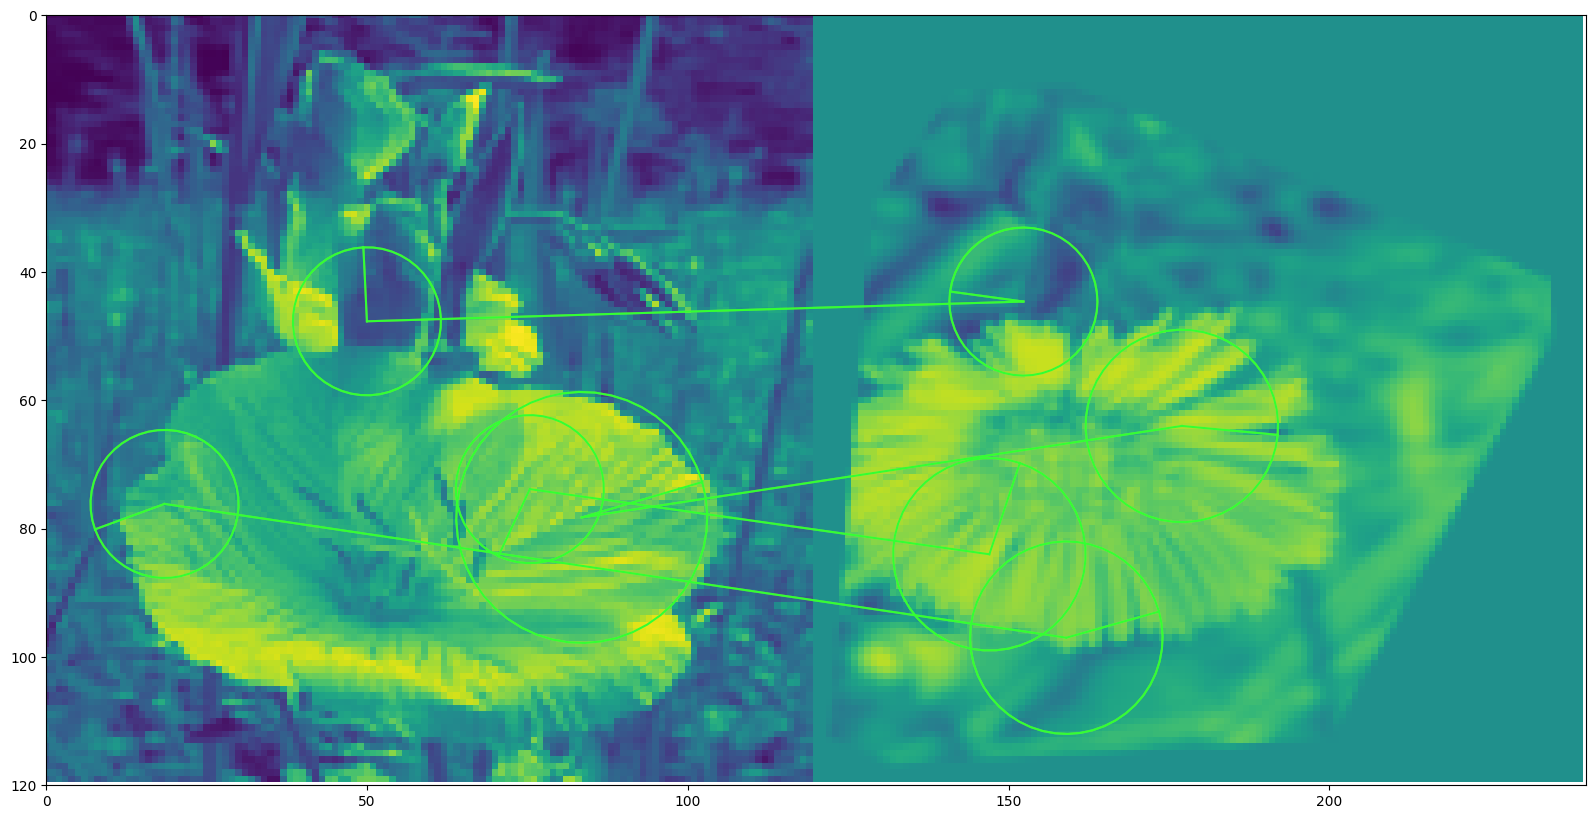

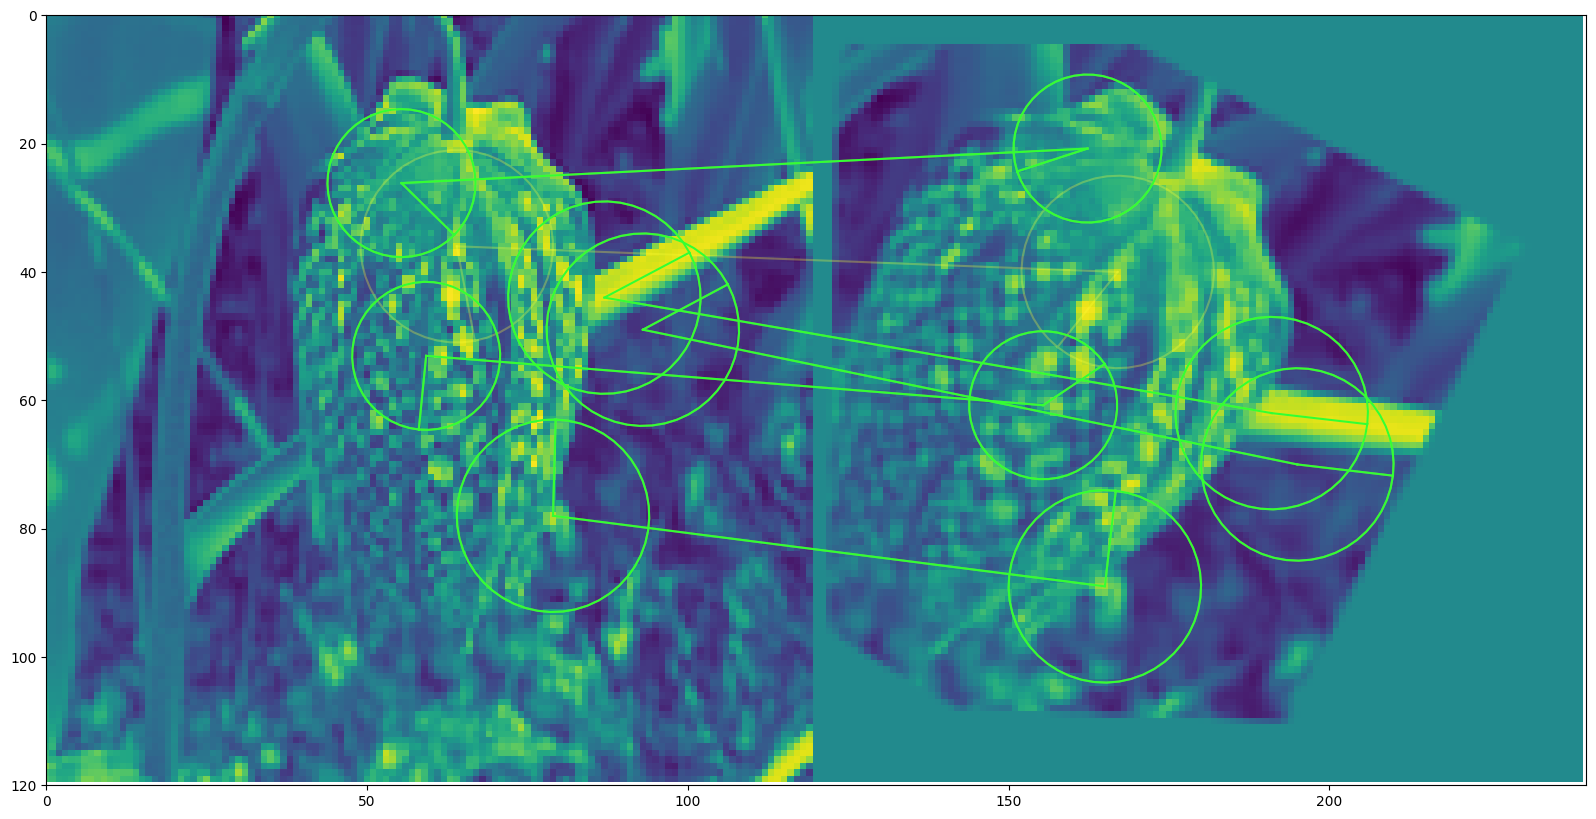

acertos:  585


In [8]:
params_lists.aug_list.data_keys =["input"]
aug_list = params_lists.aug_list

acertos = 0
total = 0
from tqdm.notebook import tqdm
pbar =  tqdm(testloader)
for imgs_batch,labels_batch in pbar:# itera em todo dataset
    imgs_batch = imgs_batch.to(sp.device)

    params_item = next(params_lists)
    timg_gray_t = aug_list(imgs_batch,params=params_item)
    plt.show()
    repo_lafs_desc= detect_extract_feat_in_batch(timg_gray_t,detector,descriptor,PS)

    for i,img_gray in enumerate(imgs_batch):# itera em cada batch
        # plot_patches_side_by_side(img_gray[:5,0])
        match_index = matching_imagens(img_gray,timg_gray_t,repo_lafs_desc,indice=i)
        # print("match_index: ",match_index," i: ",i)
        total+=1
        if match_index == i:
            acertos += 1
        pbar.set_description(f"acertos/total: {acertos}/{total}  ")
print("acertos: ",acertos)